# Cats and Dogs CNN

## Data Ingestion

In [435]:
import os
import io

# Core
import pandas as pd
import numpy as np

# Visuals
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

# Loading Zip Files
import zipfile

# Working with images
import cv2

# Progress Bar (for long processes)
from tqdm import tqdm

# Display Images
from PIL import Image, ImageFilter

# IPython display
from IPython.display import display

In [436]:
import tensorflow as tf
import time

In [437]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [438]:
RANDOM_SEED = 42

In [439]:
# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [440]:
#Change working directory
os.chdir('C:\\Users\\R\\Desktop\\MSDS 422\\cats-dogs-jump-start-v001\\cats-dogs-jump-start-v001\\cats_dogs_64-128')

print (os.getcwd())

C:\Users\R\Desktop\MSDS 422\cats-dogs-jump-start-v001\cats-dogs-jump-start-v001\cats_dogs_64-128


In [441]:
#CatsDogs# Old dimensions from MNIST no http://localhost:8888/notebooks/Desktop/MSDS%20420/Assignment_3/Assignment_3/PostgreSQL%20running%20on%20DSCC/Moderwell_Assignment_7.ipynb#loger apply
#CatsDogs# height = 28
#CatsDogs# width = 28
height = 64
width = 64   
 
# Read in cats and dogs grayscale 64x64 files to create training data
cats_1000_64_64_1 = np.load('cats_1000_64_64_1.npy')
dogs_1000_64_64_1 = np.load('dogs_1000_64_64_1.npy')
cats_1000_64_64_3 = np.load('cats_1000_64_64_3.npy')
dogs_1000_64_64_3 = np.load('dogs_1000_64_64_3.npy')



## EDA

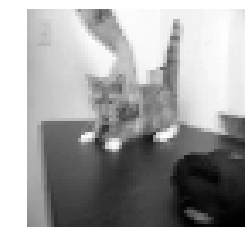

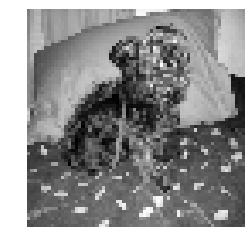

In [442]:
from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_64_64_1[0,:,:,0])
show_grayscale_image(dogs_1000_64_64_1[0,:,:,0])

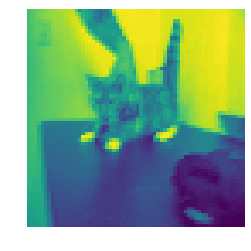

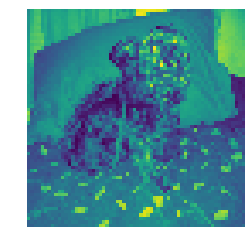

In [443]:
def show_color_image(color_image):
    plt.imshow(color_image)
    plt.axis('off')
    plt.show()
# Examine first cat and first dog grayscale images
show_color_image(cats_1000_64_64_3[0,:,:,1])
show_color_image(dogs_1000_64_64_3[0,:,:,1])

In [ ]:
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_64_64_1, dogs_1000_64_64_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) 

X_cat_dog_color = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
X_cat_dog_color = X_cat_dog_color.reshape(-1,width*height) 

# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)

y_cat_dog_color = np.concatenate((np.zeros((3000), dtype = np.int32), 
                      np.ones((3000), dtype = np.int32)), axis = 0)

# Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_cat_dog_min_max = scaler.fit_transform(X_cat_dog, y=None)


# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train, X_test, y_train, y_test = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

In [445]:
#check data shape of greyscale X variable
X_cat_dog.shape 

(2000, 4096)

In [446]:
#check data shape of color X variable
X_cat_dog_color.shape

(6000, 4096)

In [447]:
#check data shape of greyscale Y variable
y_cat_dog.shape

(2000,)

In [448]:
#check data shape of color Y variable
y_cat_dog_color.shape

(6000,)

In [449]:
#Check shape of transformed variables
X_cat_dog_min_max.shape

(2000, 4096)

## Model 1 (CNN, 5 hidden layers, 2 conv layers, max pooling)

In [615]:
#Set height and width of images
height = 64
width = 64

#Define number of nodes for hidden layers
n_hidden1 = 1000
n_hidden2 = 500
n_hidden3 = 250
n_hidden4 = 125
n_hidden5 = 75

#Used for greyscale images
channels = 1  

#Define input and output settings
n_inputs = height * width * channels 
n_outputs = 2

#CNN structure
conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64

In [616]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [617]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

In [618]:
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")


with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",activation=tf.nn.relu)
    
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",activation=tf.nn.relu)
    
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",activation=tf.nn.relu)
   
    hidden4 = neuron_layer(hidden3, n_hidden3, name="hidden4",activation=tf.nn.relu)
    
    hidden5 = neuron_layer(hidden4, n_hidden5, name="hidden5",activation=tf.nn.relu)
                           
    logits = neuron_layer(hidden5, n_outputs, name="outputs")
    

with tf.name_scope("convnet"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,strides=conv2_stride, padding=conv2_pad,activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool"):
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_flat = tf.layers.flatten(pool1)
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool1_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))  

In [619]:
%%time

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 50
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train Accuracy:", acc_train, "Test Accuracy:", acc_test)
        save_path = saver.save(sess, "./my_catdog_model1")

0 Train Accuracy: 0.515625 Test Accuracy: 0.5025
1 Train Accuracy: 0.5 Test Accuracy: 0.535
2 Train Accuracy: 0.625 Test Accuracy: 0.6225
3 Train Accuracy: 0.671875 Test Accuracy: 0.655
4 Train Accuracy: 0.625 Test Accuracy: 0.5725
5 Train Accuracy: 0.703125 Test Accuracy: 0.645
6 Train Accuracy: 0.734375 Test Accuracy: 0.6725
7 Train Accuracy: 0.78125 Test Accuracy: 0.685
8 Train Accuracy: 0.84375 Test Accuracy: 0.665
9 Train Accuracy: 0.859375 Test Accuracy: 0.67
10 Train Accuracy: 0.90625 Test Accuracy: 0.6525
11 Train Accuracy: 0.984375 Test Accuracy: 0.6675
12 Train Accuracy: 0.984375 Test Accuracy: 0.6625
13 Train Accuracy: 1.0 Test Accuracy: 0.6825
14 Train Accuracy: 0.984375 Test Accuracy: 0.6525
15 Train Accuracy: 1.0 Test Accuracy: 0.665
16 Train Accuracy: 1.0 Test Accuracy: 0.675
17 Train Accuracy: 0.96875 Test Accuracy: 0.6575
18 Train Accuracy: 1.0 Test Accuracy: 0.68
19 Train Accuracy: 1.0 Test Accuracy: 0.685
20 Train Accuracy: 1.0 Test Accuracy: 0.665
21 Train Accuracy:

In [621]:
print("Average Training Accuracy:", np.mean(acc_train))
print("Average Test Accuracy:", np.mean(acc_test))

Average Training Accuracy: 1.0
Average Test Accuracy: 0.65


## Model 2 (CNN, 5 hidden layers, 2 conv layers, avg pooling)

In [627]:
#Set height and width of images
height = 64
width = 64

#Define number of nodes for hidden layers
n_hidden1 = 1000
n_hidden2 = 500
n_hidden3 = 250
n_hidden4 = 125
n_hidden5 = 75

#Used for greyscale images
channels = 1  

#Define input and output settings
n_inputs = height * width * channels 
n_outputs = 2

#CNN structure
conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64

In [628]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [629]:
reset_graph()

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

        
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                           activation=tf.nn.relu)
    hidden4 = neuron_layer(hidden3, n_hidden3, name="hidden4",
                           activation=tf.nn.relu)
    hidden5 = neuron_layer(hidden4, n_hidden5, name="hidden5",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden5, n_outputs, name="outputs")


with tf.name_scope("convnet"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,strides=conv2_stride, padding=conv2_pad,activation=tf.nn.relu, name="conv2")
    
with tf.name_scope("pool"):
    pool1 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool_flat = tf.layers.flatten(pool1)
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))      


In [630]:
%%time

init = tf.global_variables_initializer()
saver = tf.train.Saver()  

n_epochs = 50
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train Accuracy:", acc_train, "Test Accuracy:", acc_test)
        save_path = saver.save(sess, "./my_catdog_model2")

0 Train Accuracy: 0.484375 Test Accuracy: 0.4975
1 Train Accuracy: 0.53125 Test Accuracy: 0.54
2 Train Accuracy: 0.609375 Test Accuracy: 0.645
3 Train Accuracy: 0.578125 Test Accuracy: 0.6575
4 Train Accuracy: 0.59375 Test Accuracy: 0.6325
5 Train Accuracy: 0.6875 Test Accuracy: 0.6525
6 Train Accuracy: 0.703125 Test Accuracy: 0.68
7 Train Accuracy: 0.75 Test Accuracy: 0.68
8 Train Accuracy: 0.765625 Test Accuracy: 0.695
9 Train Accuracy: 0.78125 Test Accuracy: 0.6625
10 Train Accuracy: 0.796875 Test Accuracy: 0.6625
11 Train Accuracy: 0.84375 Test Accuracy: 0.685
12 Train Accuracy: 0.90625 Test Accuracy: 0.655
13 Train Accuracy: 0.90625 Test Accuracy: 0.655
14 Train Accuracy: 0.96875 Test Accuracy: 0.635
15 Train Accuracy: 0.984375 Test Accuracy: 0.6475
16 Train Accuracy: 0.96875 Test Accuracy: 0.625
17 Train Accuracy: 1.0 Test Accuracy: 0.6425
18 Train Accuracy: 0.96875 Test Accuracy: 0.6225
19 Train Accuracy: 1.0 Test Accuracy: 0.67
20 Train Accuracy: 0.984375 Test Accuracy: 0.6625


In [632]:
print("Average Training Accuracy:", np.mean(acc_train))
print("Average Test Accuracy:", np.mean(acc_test))

Average Training Accuracy: 1.0
Average Test Accuracy: 0.6475


## Model 3 (CNN, 5 hidden layers, 2 conv layers, max pooling, 1 dropout layer)

In [604]:
#Set number of nodes for hidden layers
n_hidden1 = 1000
n_hidden2 = 500
n_hidden3 = 250
n_hidden4 = 125
n_hidden5 = 75

#Used for greyscale images
channels = 1  

#Define input and output settings
n_inputs = height * width * channels 
n_outputs = 2

#CNN structure
conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

In [605]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [606]:
reset_graph()

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")


with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                           activation=tf.nn.relu)
    hidden4 = neuron_layer(hidden3, n_hidden4, name="hidden4",
                           activation=tf.nn.relu)
    hidden5 = neuron_layer(hidden4, n_hidden5, name="hidden5",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden5, n_outputs, name="outputs")

with tf.name_scope("convnet"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,strides=conv2_stride, padding=conv2_pad,activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool"):
    pool1 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_flat = tf.layers.flatten(pool1)
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool1_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("dropout"):
    tf.layers.dropout(logits,rate=0.1,noise_shape=None,seed=RANDOM_SEED,training=True,name="dropout")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) 

In [607]:
%%time

init = tf.global_variables_initializer()
saver = tf.train.Saver()      

n_epochs = 50
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train Accuracy:", acc_train, "Test Accuracy:", acc_test)
        save_path = saver.save(sess, "./my_catdog_model3")

0 Train Accuracy: 0.515625 Test Accuracy: 0.5025
1 Train Accuracy: 0.5 Test Accuracy: 0.535
2 Train Accuracy: 0.625 Test Accuracy: 0.6225
3 Train Accuracy: 0.671875 Test Accuracy: 0.655
4 Train Accuracy: 0.625 Test Accuracy: 0.5725
5 Train Accuracy: 0.703125 Test Accuracy: 0.645
6 Train Accuracy: 0.734375 Test Accuracy: 0.6725
7 Train Accuracy: 0.78125 Test Accuracy: 0.685
8 Train Accuracy: 0.84375 Test Accuracy: 0.665
9 Train Accuracy: 0.859375 Test Accuracy: 0.67
10 Train Accuracy: 0.90625 Test Accuracy: 0.6525
11 Train Accuracy: 0.984375 Test Accuracy: 0.6675
12 Train Accuracy: 0.984375 Test Accuracy: 0.6625
13 Train Accuracy: 1.0 Test Accuracy: 0.6825
14 Train Accuracy: 0.984375 Test Accuracy: 0.6525
15 Train Accuracy: 1.0 Test Accuracy: 0.665
16 Train Accuracy: 1.0 Test Accuracy: 0.675
17 Train Accuracy: 0.96875 Test Accuracy: 0.6575
18 Train Accuracy: 1.0 Test Accuracy: 0.68
19 Train Accuracy: 1.0 Test Accuracy: 0.685
20 Train Accuracy: 1.0 Test Accuracy: 0.665
21 Train Accuracy:

In [609]:
print("Average Training Accuracy:", np.mean(acc_train))
print("Average Test Accuracy:", np.mean(acc_test))

Average Training Accuracy: 1.0
Average Test Accuracy: 0.65


## Model 4 (CNN, 5 hidden layers, 2 conv layers, average pooling,1 dropout layer)

In [610]:
# 300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron
n_hidden1 = 1000
n_hidden2 = 500
n_hidden3 = 250
n_hidden4 = 125
n_hidden5 = 75

#Used for greyscale images
channels = 1  

#Define input and output settings
n_inputs = height * width * channels 
n_outputs = 2

#CNN structure
conv1_fmaps = 64
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64

In [611]:
reset_graph()


X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [612]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
        
        
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                           activation=tf.nn.relu)
    hidden4 = neuron_layer(hidden3, n_hidden4, name="hidden4",
                           activation=tf.nn.relu)
    hidden5 = neuron_layer(hidden4, n_hidden5, name="hidden5",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden5, n_outputs, name="outputs")

with tf.name_scope("convnet"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,strides=conv1_stride, padding=conv1_pad,activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,strides=conv2_stride, padding=conv2_pad,activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool"):
    pool1 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool1_flat = tf.layers.flatten(pool1)
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool1_flat, n_fc1, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")    

with tf.name_scope("dropout"):
    dropout = tf.layers.dropout(logits,rate=0.1,noise_shape=None,seed=RANDOM_SEED,training=True,name="dropout")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) 

In [613]:
%%time

init = tf.global_variables_initializer()
saver = tf.train.Saver()      

n_epochs = 50
batch_size = 64

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train.shape[0] // batch_size):
            X_batch = X_train[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        save_path = saver.save(sess, "./my_catdog_model3")

0 Train accuracy: 0.44921875 Test accuracy: 0.4975
1 Train accuracy: 0.44921875 Test accuracy: 0.4975
2 Train accuracy: 0.46484375 Test accuracy: 0.52
3 Train accuracy: 0.4609375 Test accuracy: 0.5125
4 Train accuracy: 0.578125 Test accuracy: 0.565
5 Train accuracy: 0.5859375 Test accuracy: 0.5925
6 Train accuracy: 0.63671875 Test accuracy: 0.62
7 Train accuracy: 0.65234375 Test accuracy: 0.55
8 Train accuracy: 0.671875 Test accuracy: 0.5825
9 Train accuracy: 0.6484375 Test accuracy: 0.6075
10 Train accuracy: 0.69140625 Test accuracy: 0.615
11 Train accuracy: 0.6484375 Test accuracy: 0.605
12 Train accuracy: 0.73046875 Test accuracy: 0.6625
13 Train accuracy: 0.734375 Test accuracy: 0.675
14 Train accuracy: 0.71484375 Test accuracy: 0.66
15 Train accuracy: 0.7578125 Test accuracy: 0.6875
16 Train accuracy: 0.76171875 Test accuracy: 0.6825
17 Train accuracy: 0.77734375 Test accuracy: 0.685
18 Train accuracy: 0.7421875 Test accuracy: 0.67
19 Train accuracy: 0.77734375 Test accuracy: 0.68

In [614]:
print("Average Training Accuracy:", np.mean(acc_train))
print("Average Test Accuracy:", np.mean(acc_test))

Average Training Accuracy: 0.99609375
Average Test Accuracy: 0.67


## Conclusion

Based on the results, it is recommended that management uses Model 1. It was observed that these models suffer from overfitting and that while training accuracy is around 99% to 100%, testing accuracy plateaus around 68% to 70%. Adding a dropout layer had little effect on both time and accuracy for both types of models (average pooling and maximum pooling). It is recommended that further experimentation take place on the number of convolutional/pooling layers as well as the structure of these layers.